# Wildfire Detection - by Selman Tabet @ https://selman.io/

In [23]:
import os
import time


### Environment Setup

In [24]:

print(os.getcwd())

d:\Dissertation\Kaggle Data\wildfire-detection


In [25]:
import socket
print(socket.gethostname())
import os
import sys
try:
    os.system("nvidia-smi")
except:
    pass

Chaos


### Importing Libraries

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2, InceptionV3, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetV2S
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc


import seaborn as sns
from tensorflow.keras.utils import plot_model

from train_parameters import *

### Environment Setup

In [27]:
DATASETS = {
    "dataset_1": {
        "train": os.path.join("dataset_1", "train"),
        "test": os.path.join("dataset_1", "test"),
        "val": os.path.join("dataset_1", "val"),
        "augment": False
    },
    "dataset_2": {
        "train": os.path.join("dataset_2", "Training and Validation"),
        "test": os.path.join("dataset_2", "Testing"),
        "augment": False
    },
}
train_dirs = [DATASETS[dataset].get('train') for dataset in DATASETS]
test_dirs = [DATASETS[dataset].get('test') for dataset in DATASETS]
val_dirs = [DATASETS[dataset].get('val') for dataset in DATASETS]

print(DATASETS)
print(train_dirs)
print(test_dirs)
print(val_dirs)
data_set = list(zip(train_dirs, test_dirs, val_dirs))
print(data_set)

base_models = [ResNet50V2, InceptionV3, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetV2S]

{'dataset_1': {'train': 'dataset_1\\train', 'test': 'dataset_1\\test', 'val': 'dataset_1\\val', 'augment': False}, 'dataset_2': {'train': 'dataset_2\\Training and Validation', 'test': 'dataset_2\\Testing', 'augment': False}}
['dataset_1\\train', 'dataset_2\\Training and Validation']
['dataset_1\\test', 'dataset_2\\Testing']
['dataset_1\\val', None]
[('dataset_1\\train', 'dataset_1\\test', 'dataset_1\\val'), ('dataset_2\\Training and Validation', 'dataset_2\\Testing', None)]


In [28]:
print(tf.config.get_visible_devices())
# print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Initialize data generators with augmentation

In [29]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [30]:
batch_size = 32
img_height, img_width = 224, 224  # ResNet50V2/EfficientNet expects 224x224 images

### Auxiliary Functions

In [ ]:
def samples_from_generators(generators):
    samples = 0
    for generator in generators:
        if generator is not None:
            samples += generator.samples
    return samples

# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def val_split(dataset, samples=None, val_size=0.2):
    # Calculate the number of samples for validation and training
    val_size = int(val_size * samples)
    train_size = samples - val_size
    # Print the sizes of the datasets
    print("Splitted dataset:")
    print(f"Training dataset size: {train_size} samples")
    print(f"Validation dataset size: {val_size} samples")
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    return train_dataset, val_dataset, train_size, val_size

def create_generators(directory, batch_size=32, img_height=224, img_width=224, augment=True):
    generator = original_datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',
        shuffle=True
    )
    if augment:
        augmented_generator = augmented_datagen.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=True
        )
        return generator, augmented_generator
    return generator, None

def dir_to_dataset(directory, batch_size=32, img_height=224, img_width=224, augment=False):
    generator, augmented_generator = create_generators(directory, batch_size, img_height, img_width, augment)
    dataset = create_dataset(generator, batch_size)
    if augmented_generator is not None:
        augmented_dataset = create_dataset(augmented_generator, batch_size)
        combined_dataset = dataset.concatenate(augmented_dataset)
        return combined_dataset
    return dataset

### Model Evaluation Functions

In [ ]:
def generate_roc_curve(model, val_dataset, directory, dataset_name):
    # Generate predictions on the validation set
    y_pred_probs = model.predict(val_dataset)

    # Calculate ROC curve and AUC
    true_labels = np.concatenate([y for x, y in val_dataset], axis=0)
    fpr, tpr, thresholds = roc_curve(true_labels, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(directory, f'roc_curve_{dataset_name}.png'))
    plt.close()

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
    
def generate_confusion_matrices(cm, directory, dataset_name):
    class_names = ['fire', 'nofire']
    # Save the confusion matrix plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(directory, f'confusion_matrix_{dataset_name}.png'))
    plt.close()

# Function to plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # precision = history.history.get('precision', [])
    # val_precision = history.history.get('val_precision', [])
    epochs = range(len(acc))

    plt.figure(figsize=(12, 12))
    
    # Plot accuracy
    plt.subplot(3, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(3, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    # # Plot precision
    # plt.subplot(3, 1, 3)
    # plt.plot(epochs, precision, label='Training Precision')
    # plt.plot(epochs, val_precision, label='Validation Precision')
    # plt.title('Training and Validation Precision')
    # plt.legend()
    # plt.show()

### File Save/Load Functions

In [ ]:
def save_history(run_dir, history, model_name, dataset_name):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(run_dir, f"history_{model_name}_{dataset_name}.csv"), index=False)

### Generate training and validation datasets

In [ ]:

train_datasets = [] # [ (dataset_1_train, dataset_2_train), ... ]
train_sizes = [] # [ (dataset_1_train_size, dataset_2_train_size), ... ]
val_datasets = [] # [ (dataset_1_val, dataset_2_val), ... ]
val_sizes = [] # [ (dataset_1_val_size, dataset_2_val_size), ... ]
# data_dict = {}
for d in DATASETS:
    print(f"Processing: {d}")
    train_dir = DATASETS[d]['train']
    augment = DATASETS[d].get('augment', True)
    print("Augmenting" if augment else "Not augmenting", d)
    # Apply original and augmented data generators for training
    print("Creating generators for training")
    train_generator, augmented_train_generator = create_generators(train_dir, augment=augment)
    train_samples = samples_from_generators([train_generator, augmented_train_generator])  
    train_dataset = dir_to_dataset(train_dir, batch_size=batch_size, augment=augment)
    
    # Apply original and augmented data generators for validation
    if "val" in DATASETS[d]:
        val_dir = DATASETS[d]['val']
        print("Creating generators for validation")
        val_generator, augmented_val_generator = create_generators(val_dir, augment=augment)
        val_samples = samples_from_generators([val_generator, augmented_val_generator])
        val_dataset = dir_to_dataset(val_dir, batch_size=batch_size, augment=augment)
    else:
        train_dataset, val_dataset, train_samples, val_samples = val_split(train_dataset, train_samples)
        val_generator, augmented_val_generator = None, None
    
    # Calculate the number of samples for training and validation
    train_sizes.append(train_samples)
    val_sizes.append(val_samples)

    class_indices = train_generator.class_indices
    print("Class indices:", class_indices)
    class_names = list(class_indices.keys())
    print("Class names:", class_names)

    original_class_counts = {class_name: 0 for class_name in class_names}
    augmented_class_counts = {class_name: 0 for class_name in class_names}

    for class_name, class_index in class_indices.items():
        original_class_counts[class_name] = sum(train_generator.classes == class_index)
        if augmented_train_generator is not None:
            augmented_class_counts[class_name] = sum(augmented_train_generator.classes == class_index)

    # Print the results
    print("Dataset Class Counts:")
    for class_name, count in original_class_counts.items():
        print(f"{class_name}: {count}")
    if augmented_train_generator is not None:
        print("\nAugmented Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count}")
        print("\n")
        print("Combined Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count + original_class_counts[class_name]}")
    print("\n")
    
    # data_dict[d] = {
    #     "train": train_dataset,
    #     "val": val_dataset,
    #     "train_generator": train_generator,
    #     "augmented_train_generator": augmented_train_generator,
    #     "val_generator": val_generator,
    #     "augmented_val_generator": augmented_val_generator,
    #     "train_samples": train_samples,
    #     "val_samples": val_samples
    # }
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)

# Ensure that the lengths are consistent across the board
assert(len(train_sizes) == len(train_datasets) and len(train_sizes) == len(val_sizes) and len(val_sizes) == len(val_datasets))
    

Processing: dataset_1
Not augmenting dataset_1
Creating generators for training
Found 2815 images belonging to 2 classes.
Found 2815 images belonging to 2 classes.
Creating generators for validation
Found 402 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Class indices: {'fire': 0, 'nofire': 1}
Class names: ['fire', 'nofire']
Dataset Class Counts:
fire: 1658
nofire: 1157


Processing: dataset_2
Not augmenting dataset_2
Creating generators for training
Found 1832 images belonging to 2 classes.
Found 1832 images belonging to 2 classes.
Splitted dataset:
Training dataset size: 1466 samples
Validation dataset size: 366 samples
Class indices: {'fire': 0, 'nofire': 1}
Class names: ['fire', 'nofire']
Dataset Class Counts:
fire: 928
nofire: 904




In [33]:
steps_per_epochs = []
validation_steps_list = []

for sizes in zip(train_sizes, val_sizes):
    steps_per_epochs.append(sizes[0] // batch_size)
    validation_steps_list.append(sizes[1] // batch_size)

### Generate test datasets

In [ ]:
test_datasets = [] # [ (dataset_1_test, dataset_2_test), ... ]
test_generators = [] # [ (dataset_1_test_generator, dataset_2_test_generator), ... ]
for d in DATASETS:
    print(f"Processing test dataset: {d}")
    test_dir = DATASETS[d]['test']
    augment = False # No augmentation for testing
    test_generator, augmented_test_generator = create_generators(test_dir, augment=augment)
    test_dataset = create_dataset(test_generator)
    
    print("Class indices:", test_generator.class_indices)
    print("\n")
    print("Test Dataset Class Counts:")
    for class_name, class_index in test_generator.class_indices.items():
        print(f"{class_name}: {sum(test_generator.classes == class_index)}")
    print("\n")
    test_generators.append(test_generator)
    test_datasets.append(test_dataset)


Processing test dataset: dataset_1
Creating generators for testing
Found 410 images belonging to 2 classes.
Class indices: {'fire': 0, 'nofire': 1}


Test Dataset Class Counts:
fire: 159
nofire: 251


Processing test dataset: dataset_2
Creating generators for testing
Found 68 images belonging to 2 classes.
Class indices: {'fire': 0, 'nofire': 1}


Test Dataset Class Counts:
fire: 22
nofire: 46




### Data Visualization

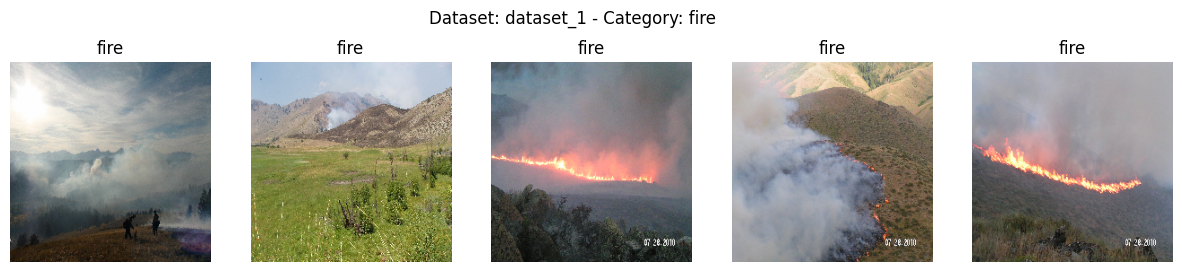

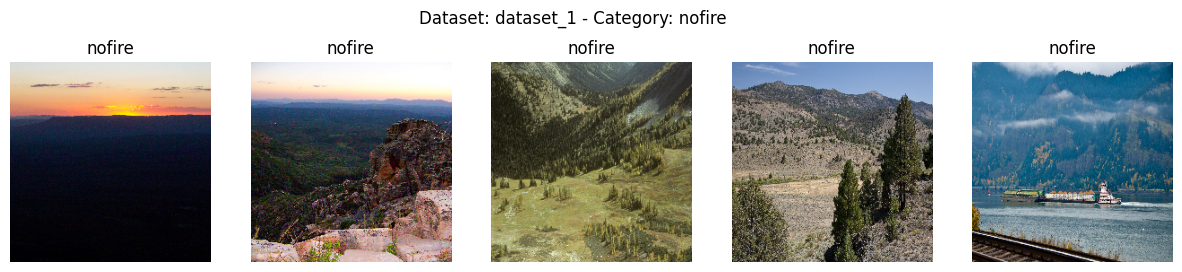

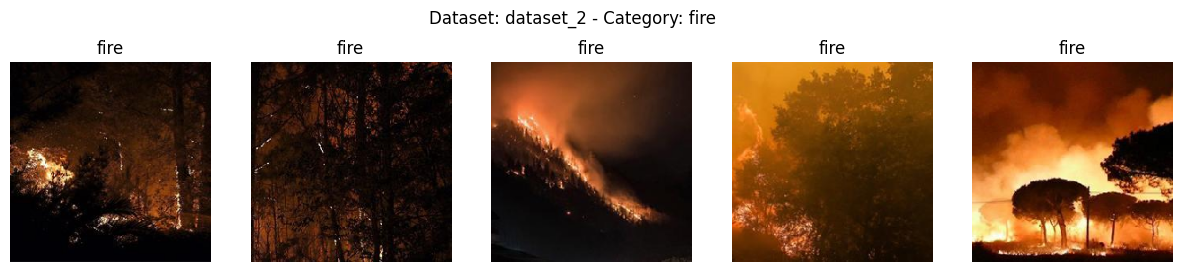

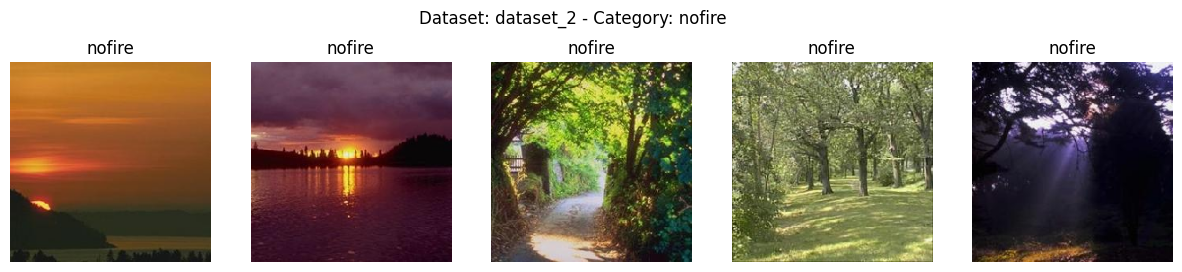

In [35]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    dataset_name = os.path.basename(os.path.dirname(directory))
    plt.suptitle(f"Dataset: {dataset_name} - Category: {category}", y=0.8)
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

for train_dir in train_dirs:
    # Plotting 5 fire and 5 nofire images
    plot_images(train_dir, 'fire', 5)
    plot_images(train_dir, 'nofire', 5)



### Model Preparation

In [ ]:
models = []

for bm in base_models:
    base_model = bm(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )

    base_model.trainable = False

    callback = EarlyStopping(monitor='loss', patience=3)

    # Create the model
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name=bm.__name__)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    models.append(model)

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

Model: "InceptionV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_210         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_211         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,336,801 (85.21 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_212         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_213         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,345 (56.65 MB)

 Trainable params: 133,121 (520.00 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_214         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_215         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,159,041 (76.90 MB)

 Trainable params: 133,121 (520.00 KB)

 Non-trainable params: 20,025,920 (76.39 MB)

Model: "Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_220         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_221         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,395,497 (81.62 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 20,866,088 (79.60 MB)

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_222         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_223         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,321 (9.89 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_224         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_225         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,281 (27.87 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_226         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_227         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,665,697 (78.83 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 20,334,432 (77.57 MB)

### Training the models

In [ ]:
training_results = {}
run_number = len([d for d in os.listdir("runs") if os.path.isdir(os.path.join("runs", d)) and d.startswith('run_')]) + 1
run_dir = os.path.join("runs", f"run_{run_number}")
os.makedirs(run_dir, exist_ok=True)

for model in models:
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=f"{model.name}_architecture.png")
    for train_dir, train_dataset, val_dataset, steps_per_epoch, validation_steps in zip(train_dirs, train_datasets, val_datasets, steps_per_epochs, validation_steps_list):
        dataset = os.path.basename(os.path.dirname(train_dir))
        print(f"Training model: {model.name} on dataset: {dataset}")

        # Record the start time
        start_time = time.time()

        # Initial training
        epochs = 50
        history = model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            callbacks=[callback]
        )

        # Record the end time
        end_time = time.time()

        model_dir = os.path.join(run_dir, model.name)
        os.makedirs(model_dir, exist_ok=True)
        # Save the history to a CSV file
        save_history(model_dir, history, model.name, dataset)
        
        optimal_threshold = generate_roc_curve(model, val_dataset, model_dir, dataset)

        # Save the model
        model.save(os.path.join(model_dir, f"{model.name}_{dataset}.keras"))

        # Calculate the training time
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        training_results[(model.name, dataset)] = {
            'history': history.history,
            'training_time': training_time,
            'optimal_threshold': optimal_threshold
        }
        print(training_results)
        
        

### Model Evaluation

In [ ]:
print("Training data evaluation\n", model.evaluate(combined_dataset, steps=steps_per_epoch))
print("Test data evaluation\n", model.evaluate(test_dataset, steps=validation_steps))

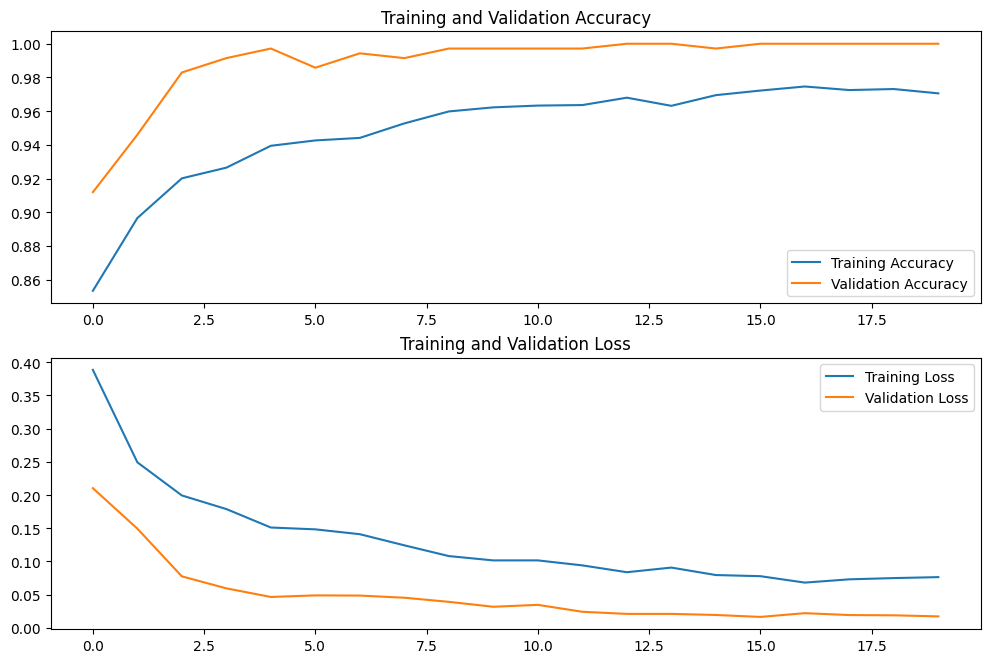

In [ ]:


plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


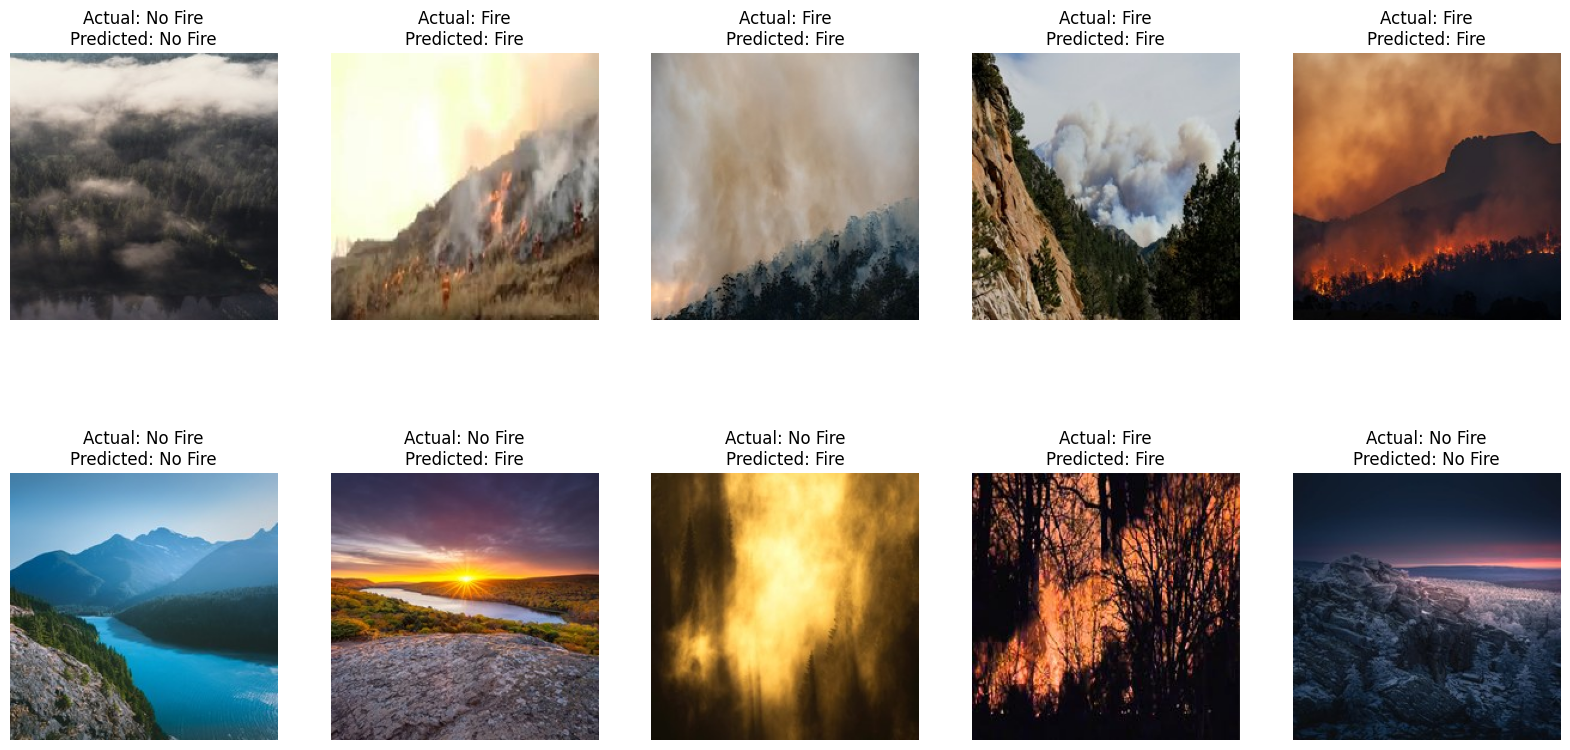

In [49]:
test_generator.reset()
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= 0.5 else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

> **NOTE:** Due to alphabetical order "Fire" is labelled as "0" and "No Fire" is labelled as "1"

### 50% Threshold

d:\Dissertation\Kaggle Data\Wildfire Combined\forest_fire\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 618ms/step


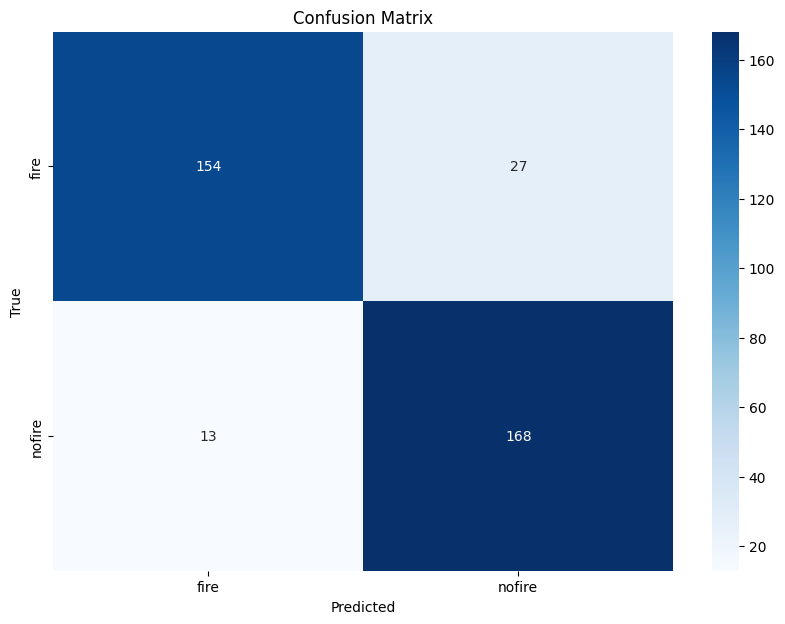

In [50]:

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) >= 0.5).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Optimal Threshold

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step


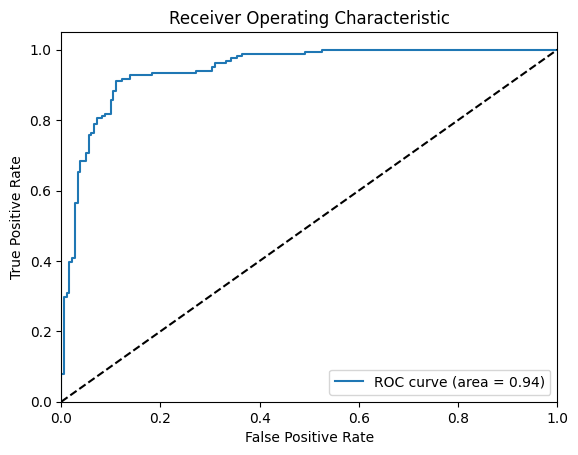

Optimal Threshold: 0.64908445


In [52]:
import numpy as np
from sklearn.metrics import roc_curve, auc


# Generate predictions on the validation set
# Generate predictions on the test set
y_pred_probs = model.predict(test_generator)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


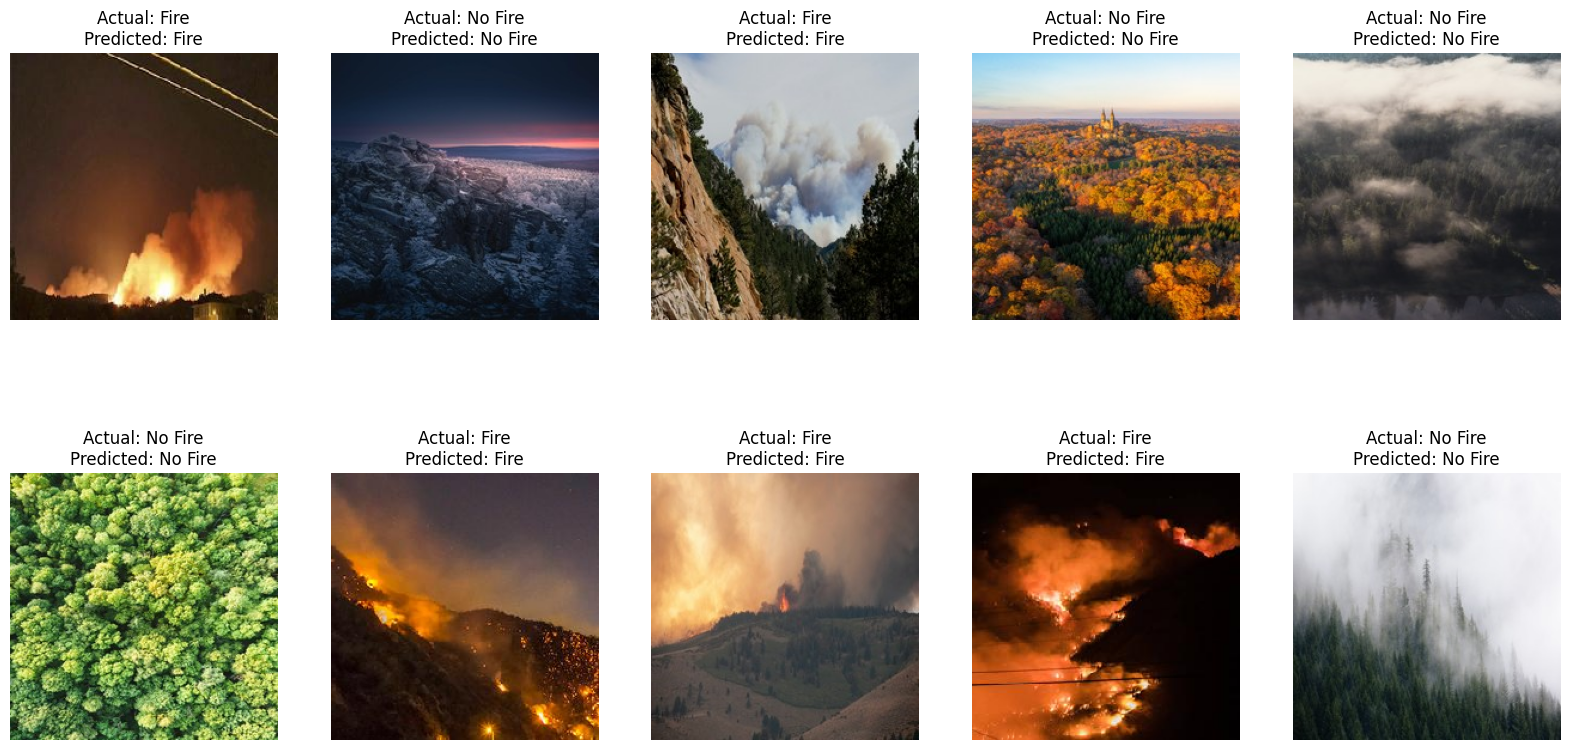

In [53]:
test_generator.reset()
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= optimal_threshold else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step


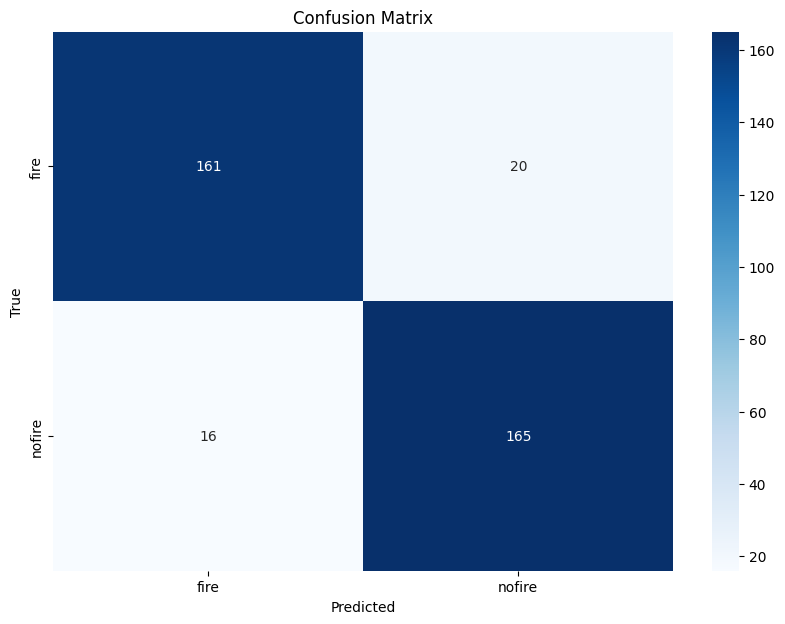

In [54]:

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) >= optimal_threshold).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Save all files

In [ ]:
hist_df = pd.DataFrame(history.history) 
# Save the optimal threshold to a file
with open('optimal_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))

# Create directory structure
base_model_name = base_model.name
run_dirs = [d for d in os.listdir(base_model_name) if os.path.isdir(os.path.join(base_model_name, d)) and d.startswith('run_')]
run_number = len(run_dirs) + 1
run_dir = os.path.join(base_model_name, f'run_{run_number}')

os.makedirs(run_dir, exist_ok=True)

# Save the model, history, and optimal threshold in the new directory
model.save(os.path.join(run_dir, 'wildfire_detection_model.keras'))
hist_df.to_csv(os.path.join(run_dir, 'history.csv'), index=False)
with open(os.path.join(run_dir, 'optimal_threshold.txt'), 'w') as f:
    f.write(str(optimal_threshold))

# Save the confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
plt.close()

# Save the training/validation accuracy and loss graphs
plot_history(history)
plt.savefig(os.path.join(run_dir, 'training_validation_accuracy_loss.png'))
plt.close()


# Save the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(os.path.join(run_dir, 'roc_curve.png'))
plt.close()

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Save the training time to a file
with open(os.path.join(run_dir, 'training_time.txt'), 'w') as f:
    f.write(f"{training_time:.6f}")